In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [6]:
tracking_df['gpid'] = tracking_df.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [7]:
runners = tracking_df.loc[(tracking_df['position'].isin(['WR'])) & (~tracking_df['route'].isna())].copy()

In [8]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [14]:
gpids = runners['gpid'].unique().tolist()

In [16]:
runners.head()

,time,s,a,dis,event,nflId,displayName,jerseyNumber,position,frameId,...,gameId,playId,playDirection,route,pos,teamType,o_vec,dir_vec,r_vec,gpid
1,2018-09-07 01:07:14.599000+00:00,0.02,0.03,0.01,None,2495454,Julio Jones,11,WR,1,...,2018090600,75,left,HITCH,"[28.65, 9.14]",offense,"[0.93697745, -0.34938985]","[-0.29003414, -0.9570163]","[0.12496368, -0.99216132]",2018090600-75
2,2018-09-07 01:07:14.599000+00:00,0.00,0.00,0.00,None,2533040,Mohamed Sanu,12,WR,1,...,2018090600,75,left,HITCH,"[29.22, 17.15]",offense,"[0.97670974, 0.21456486]","[0.24141382, 0.97042226]","[0.37023815, -0.92893687]",2018090600-75
7,2018-09-07 01:07:14.700000+00:00,0.03,0.03,0.02,None,2495454,Julio Jones,11,WR,2,...,2018090600,75,left,HITCH,"[28.63, 9.13]",offense,"[0.93697745, -0.34938985]","[-0.49409361, -0.86940871]","[0.1238431, -0.99230181]",2018090600-75
8,2018-09-07 01:07:14.700000+00:00,0.00,0.00,0.00,None,2533040,Mohamed Sanu,12,WR,2,...,2018090600,75,left,HITCH,"[29.22, 17.15]",offense,"[0.97670974, 0.21456486]","[0.18806703, 0.98215619]","[0.37111407, -0.92858729]",2018090600-75
13,2018-09-07 01:07:14.799000+00:00,0.02,0.03,0.01,None,2495454,Julio Jones,11,WR,3,...,2018090600,75,left,HITCH,"[28.63, 9.13]",offense,"[0.93697745, -0.34938985]","[-0.53287628, -0.84619317]","[0.12371046, -0.99231836]",2018090600-75


In [34]:
routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
index = 0
end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

# Generate vectors of positions
for gpid in gpids[:100]:
    df = runners.loc[runners['gpid'] == gpid]
    players = df['nflId'].unique().tolist()
    for player in players:
        player_df = df.loc[(df['nflId'] == player)]
        if player > 0:
            start_frame = df.loc[(df['nflId'] == player) & (df['event'] == 'ball_snap')]['frameId'].min()
            end_frame = df.loc[(df['nflId'] == player) & (df['event'].isin(end_events))]['frameId'].min()
            if end_frame > start_frame:
                positions = []
                for frame in range(start_frame + 1, end_frame + 1):
                    positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                positions = np.array(positions)
                try:
                    routes_df.loc[index] = {
                        'gpid': str(),
                        'nflId': int(player),
                        'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                        'pos': positions - positions[0]
                    }
                    index += 1
                except IndexError:
                    print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')

In [18]:
# Convert position sequences to 2d array with np.histogram2d

In [19]:
# Convert 2d array to 1d array

(-15.39, 12.82)

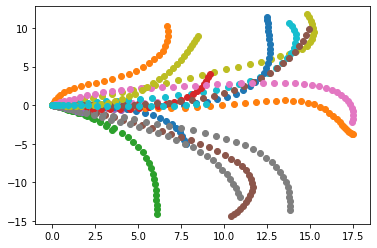

In [42]:
x = [0, 0]
y = [0, 0]
for idx, row in routes_df.loc[(routes_df['route'] == 'OUT')].iterrows():
    if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
    if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
    if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
    if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()
    plt.scatter(row['pos'][:, 0], row['pos'][:, 1])
plt.xlim(x[0] - 1, x[1] + 1)
plt.ylim(y[0] - 1, y[1] + 1)